<div style="color:#8b1538; font-size:32px;">Graphic representation using matplotlib and seaborn</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

# Common method

> Heatmap personnalization - xaxis and yaxis

In [2]:
def heatmap_axis(ax, xaxis, yaxis, cbar):
    """
    ax: matplotlib.axes.Axes
        ax to modify
    xaxis: str
        x-axis label
    yaxis: str
        y-axis label
    cbar: str
        colormap label
    """
    # Name
    names = ["Log10({})".format(xaxis), "Log10({})".format(yaxis)]  # (xaxis, yaxis)
    
    # x-axis
    plt.xticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-4, 2.5, 0.7)], rotation='horizontal')
    plt.xlabel(names[0], fontsize="large")
    
    # y-axis
    ax.set_ylim(ax.get_ylim()[::-1])  # reverse y-axis
    plt.yticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-3.5, 3, 0.7)])
    plt.ylabel(names[1], fontsize="large")
    
    # Set colorbar label & font size
    ax.figure.axes[-1].set_ylabel(cbar, fontsize="large")

<br>

# SFS shape verification

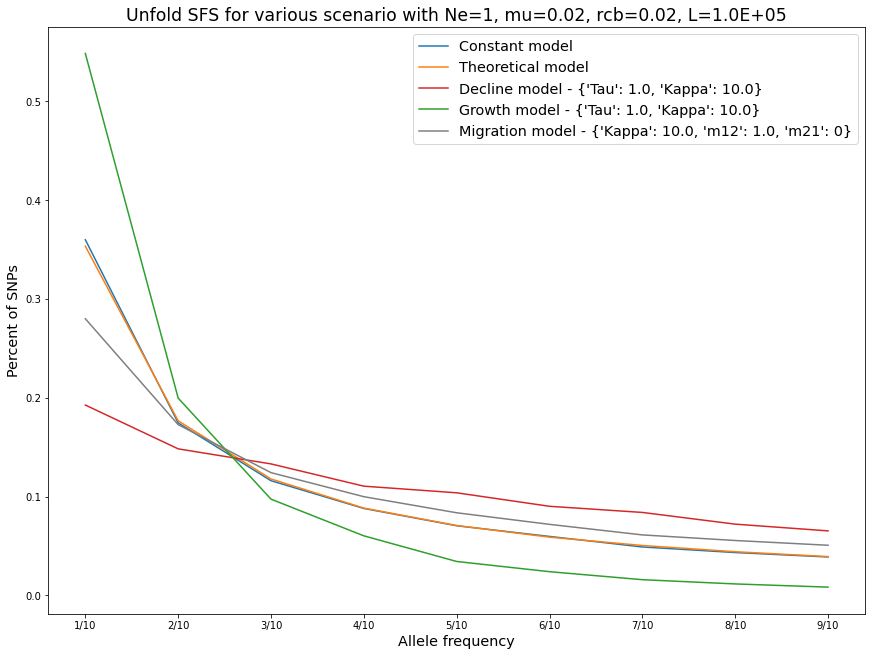

In [3]:
data = f.load_sfs(function=sei.generate_set_sfs)
plot.plot_sfs(data)

**Constant model**. Constant size population model. **Theoritical model**. Theoritical SFS for any constant population. **Decline model**. sudden decline of an ancestral population of size Ne\*kappa to size Ne at a time tau in the past. **Growth model**. sudden growth of an ancestral population of size Ne to size Ne\*kappa at a time tau in the past. **Migration model**. migration model of two populations pop1 and pop2 of size Ne and Ne\*kappa respectively. m12 is the migration rate into 1 from 2 and m21 is the migration rate into 2 from 1 (by default m21 s 0)

<br>

# SNPs distribution

> Load data

In [4]:
def load_data(filin, path_data):
    return pd.read_json(path_or_buf="{}{}".format(path_data, filin), typ='frame')

> Data pre-processing

In [5]:
def data_preprocessing(sfs):
    # New pandas DataFrame
    data = pd.DataFrame()
    
    # Compute log10 of parameters - either (tau, kappa) or (m12, kappa)
    keys = sfs['Parameters'][0].keys()
    names = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            names.append(key)
            data[key] = sfs['Parameters'].apply(lambda param: param[key])
    
    # Compute mean(SNPs)
    data['SNPs'] = sfs['SNPs'].apply(lambda snp: np.log10(np.mean(snp)))

    return data.pivot(names[1], names[0], 'SNPs')

> Plot data

In [6]:
def plot_snp_distribution(data, model):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(data, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=data.columns.name, yaxis=data.index.name, cbar="SNPs - log scale")
    
    # Title
    title = "SNPs distribution in terms of {} & {} - {} model".format(data.columns.name, data.index.name, model)
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.show()

<br>

### SNPs distribution - decline model

> By default

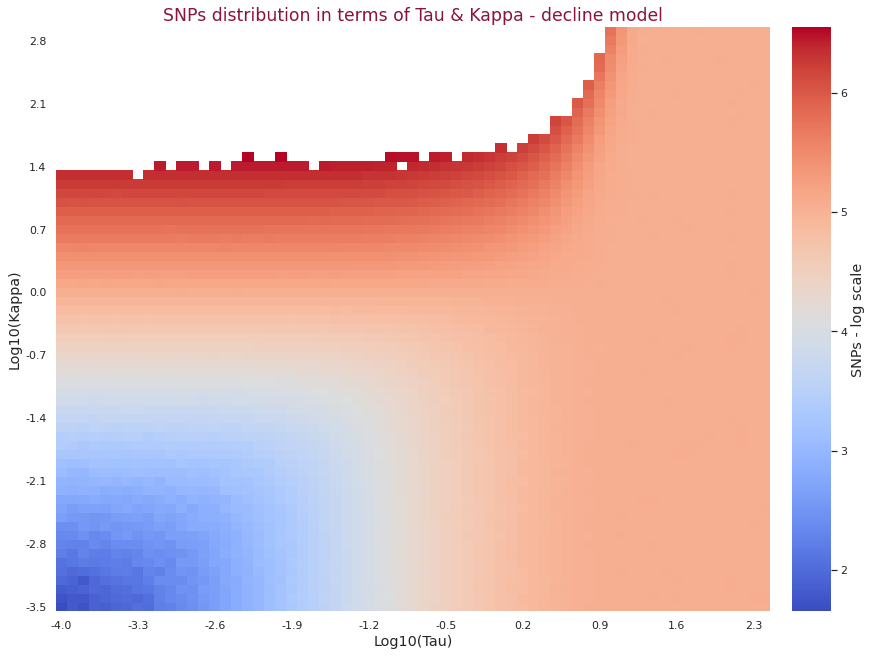

In [7]:
filin, path_data = "SFS_decline-default","./Data/Msprime/snp_distribution/decline/"
data = data_preprocessing(load_data(filin, path_data))
plot_snp_distribution(data, "decline")

Il y a une grande disparité dans le nombre de SNPs en fonction de tau & kappa.

<br>

> About 100 000 SNPs for each observed SFS

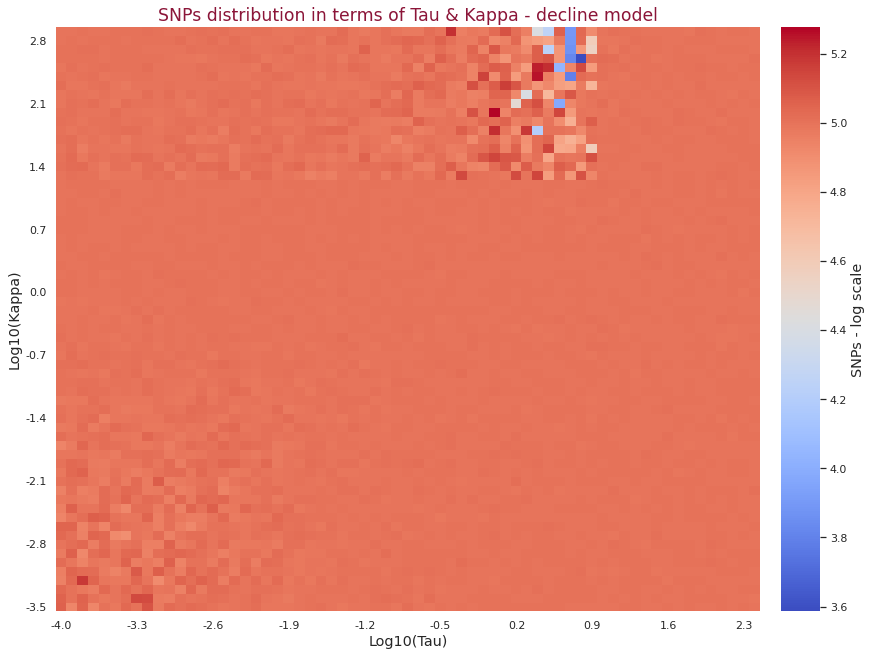

In [8]:
filin, path_data = "SFS_decline-fixed","./Data/Msprime/snp_distribution/decline/"
data = data_preprocessing(load_data(filin, path_data))
plot_snp_distribution(data, "decline")

<br>

### SNPs distribution - decline model

> By default

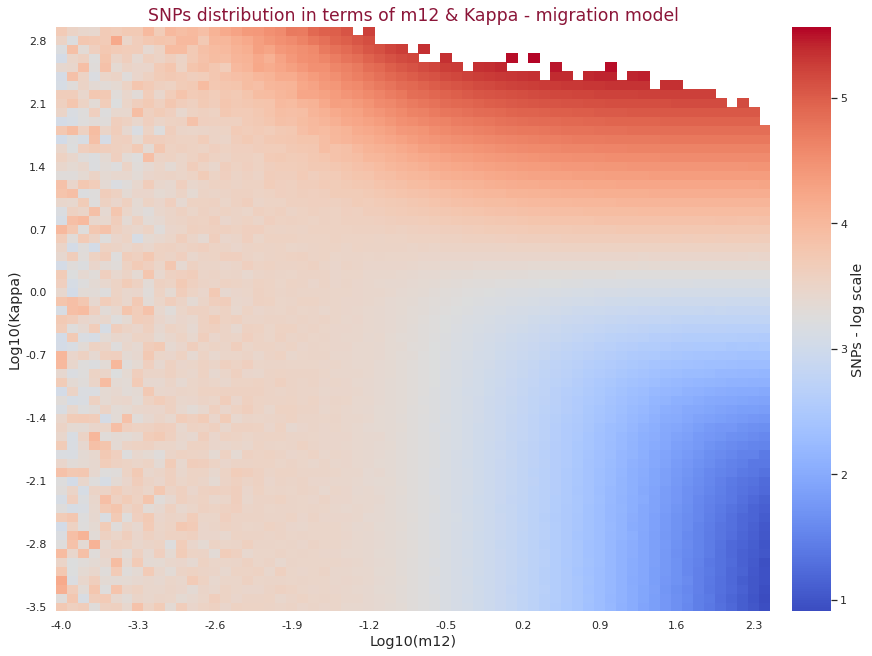

In [9]:
filin, path_data = "SFS_migration-default","./Data/Msprime/snp_distribution/migration/"
data = data_preprocessing(load_data(filin, path_data))
plot_snp_distribution(data, "migration")

Il y a une grande disparité dans le nombre de SNPs en fonction de m12 & kappa.

<br>

> About 100 000 SNPs for each observed SFS

In [10]:
#filin, path_data = "SFS_migration-fixed","./Data/Msprime/snp_distribution/migration/"
#data = data_preprocessing(load_data(filin, path_data))
#plot_snp_distribution(data, "migration")

<br>

# Dadi inference

Benchmark of dadi inference by weighted square distance & log-likelihood ratio test

<div style="color: #8b1538; font-size: 22px">1. Weighted square distance</div><br>

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$ [1]

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<br>

<div style="color: #8b1538; font-size: 15px;">[1] Each SFS must be normalized for comparison</div>

<br>

> Plot the weighted square distance - Heatmap

In [10]:
def plot_weighted_square_distance_heatmap(data, d2, models):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Data
    df = pd.DataFrame()
    for key in data['Parameters'][0].keys():  # compute log of parameters
        df[key] = data['Parameters'].apply(lambda param: round(np.log10(param[key]), 2))
    df[d2] = data[d2].apply(np.log10)  # Compute log of weighted square distance

    df = df.pivot(index=df.columns[1], columns=df.columns[0], values=d2)
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Weighted square distance - log scale')
    
    # Title
    title = "Weighted square d2 of {} & {} models".format(models[0], models[1])
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

> Plot the weighted square distance - fixed tau or kappa

In [11]:
def plot_weighted_square_distance(data, key, labels, suptitle):
    d2 = ['d2 observed inferred', 'd2 models']
    title = [
        'd2 between the observed SFS and inferred one with M1', 
        'd2 between the inferred SFS of two models (M0 & M1)'
    ]
    
    # Set-up plot
    sns.set_theme(style='whitegrid')
    
    # Sub-plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Figsize: (width, height)
    
    # Plot
    for i, ax in enumerate(axs):  # Iterate through subplot
        
        for j, dataframe in enumerate(data):  # Iterate through DataFrame in data
            # Data
            df = pd.DataFrame()
            df[key] = dataframe['Parameters'].apply(lambda param: round(np.log10(param[key]), 2))
            df[d2[i]] = dataframe[d2[i]].apply(np.log10)
            
            # Plot
            _ = sns.lineplot(x=key, y=d2[i], data=df, label=labels[j], ax=ax)
        
        ax.legend(fontsize="large")
        ax.set_title(title[i], fontsize="large")
        
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

<div style="color: #8b1538; font-size: 22px">2. Log-likelihood ratio test</div><br>

The likelihood ratio test assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

> Plot log-likelihood ratio test - heatmap

In [12]:
def plot_inference_dadi_heatmap(data):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Pre-processing data
    df = pd.DataFrame()
    for key in data['Parameters'][0].keys():  # Log10 of parameters (tau, kappa) or (m12, kappa)
        df[key] = data['Parameters'].apply(lambda param: np.log10(param[key]))  
    df['Positive hit'] = data['Positive hit']  # Add positive hit columns to df
    
    df = df.pivot(index=df.columns[1], columns=df.columns[0], values='Positive hit')
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Significant log-likelihood ratio test out of 100 tests')
    
    # Title
    title = "Log likelihood ratio test for various tau & kappa with p.value = 0.05"
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

> Plot log-likelihood ratio test - fixed tau or kappa

In [13]:
def plot_inference_dadi(data, key, labels, suptitle):
    # Set-up plot
    plt.figure(figsize=(10,8), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    for i, dataframe in enumerate(data):
        # Data
        df = pd.DataFrame()
        df[key] = dataframe['Parameters'].apply(lambda param: np.log10(param[key]))
        df['Positive hit'] = dataframe['Positive hit']
        
        # Plot
        ax = sns.lineplot(x=key, y='Positive hit', data=df, label=labels[i])
        
    ax.legend(fontsize="large")
    
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

### Heatmap - sudden decline & growth model 

> Load data

In [14]:
data_all = f.export_inference_files('decline', 'all')

<br>

> Weighted square distance - observed SFS and inferred models

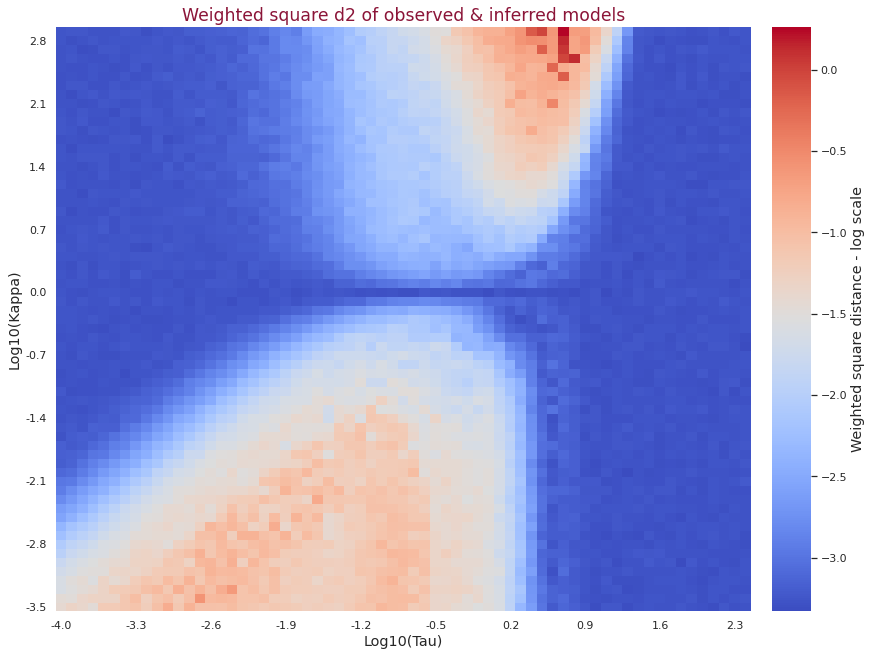

In [17]:
plot_weighted_square_distance_heatmap(data_all, 'd2 observed inferred', ['observed', 'inferred'])

<br>

> Weighted square distance - M0 & M1

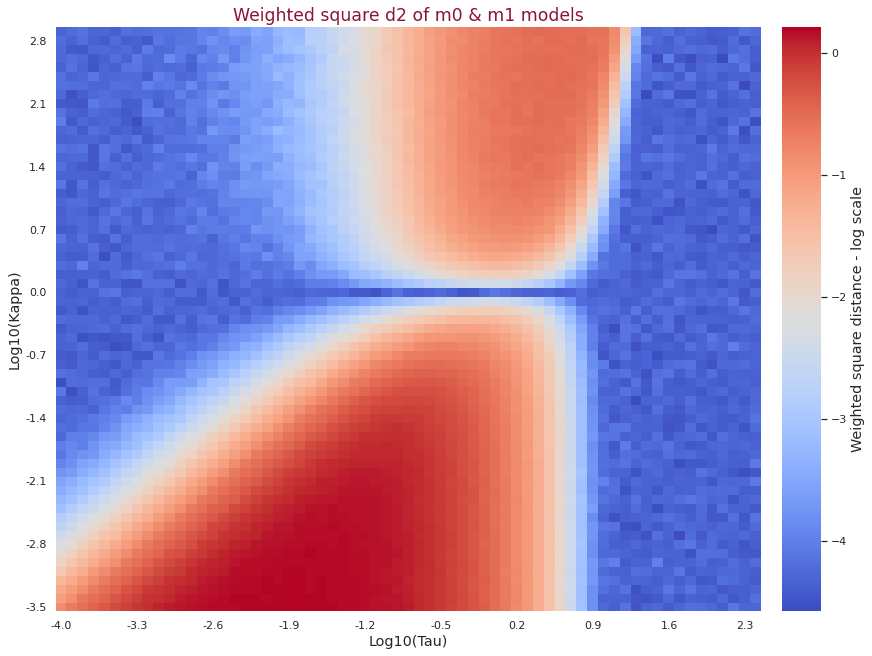

In [18]:
plot_weighted_square_distance_heatmap(data_all, 'd2 models', ['m0', 'm1'])

<br>

> Log-likelihood ratio test

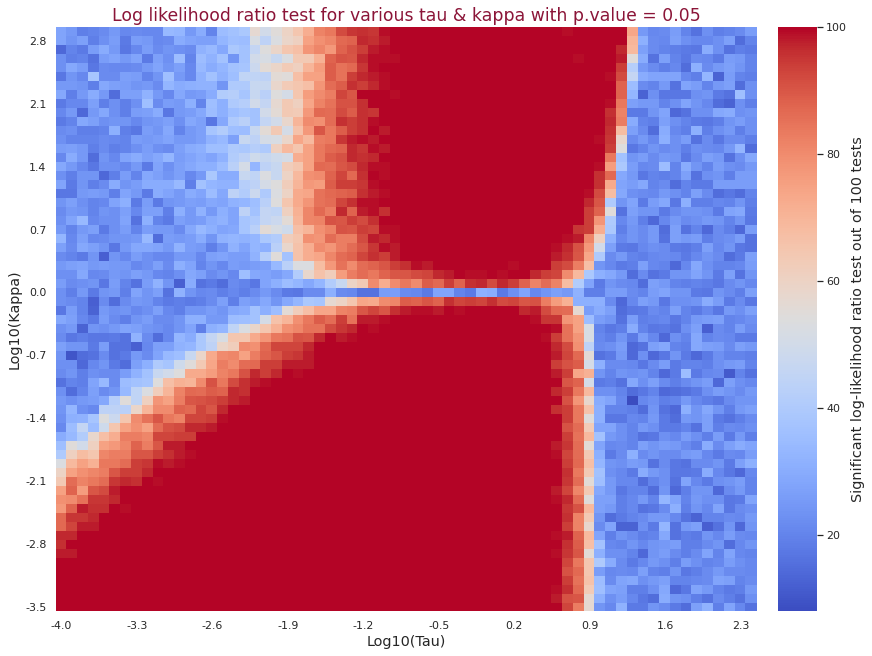

In [19]:
plot_inference_dadi_heatmap(data_all)

<br>

> Vérification paramètre Dadi

In [52]:
def compute_distance(data):
    # Compute distance between observed & estimated (Tau, kappa)
    estimated = {}
    for i, row in data.iterrows():
        estimated[i] = {}
    
        for key, observed in row['Parameters'].items():
            tmp = [np.power(observed - estimated[key], 2) / observed for estimated in row['M1']['Estimated']]
            estimated[i][key] = np.mean(tmp)

    # Creat pandas Data-Frame
    df = pd.DataFrame()
    for key in data['Parameters'][0].keys():
        df["{} observed".format(key)] = data['Parameters'].apply(lambda param: round(np.log10(param[key]), 2))
        df["{} distance".format(key)] = pd.Series(estimated).apply(lambda param: np.log10(param[key]))
        
    return df
    

def plot_distance(data):
    key = ['Tau', 'Kappa']
    title = [
        'Distance between tau observed & estimated', 
        'Distance between kappa observed & estimated'
    ]
    
    # Set-up plot
    sns.set_theme(style='whitegrid')
    
    # Sub-plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Figsize: (width, height)
    
    # Plot
    for i, ax in enumerate(axs):  # Iterate through subplot
        
        # Plot
        _ = sns.lineplot(x="{} observed".format(key[i]), y="{} distance".format(key[i]), data=data, ax=ax, marker='o', err_style='bars')

        ax.set_title(title[i], fontsize="large")
        
    plt.suptitle("Distance between observed & estimated parameters", fontsize="x-large")
    
    plt.plot()
    

def plot_inference_dadi_heatmap(data, key):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Pre-processing data
    df = pd.DataFrame()
    df = data.pivot(index="Kappa observed", columns="Tau observed", values=key)

    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar="{} - log sccale".format(key))
    
    # Title
    title = "Distance between observed & estimated {} for various (Tau, kappa)".format(key.split(' ')[0])
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

In [44]:
df = compute_distance(data_all)

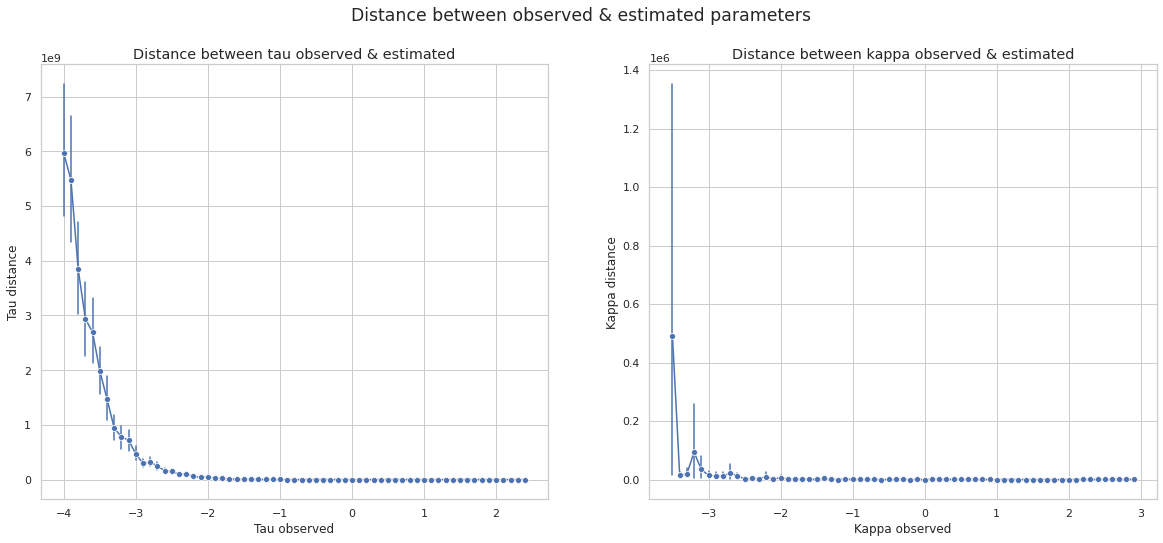

In [23]:
plot_distance(df)

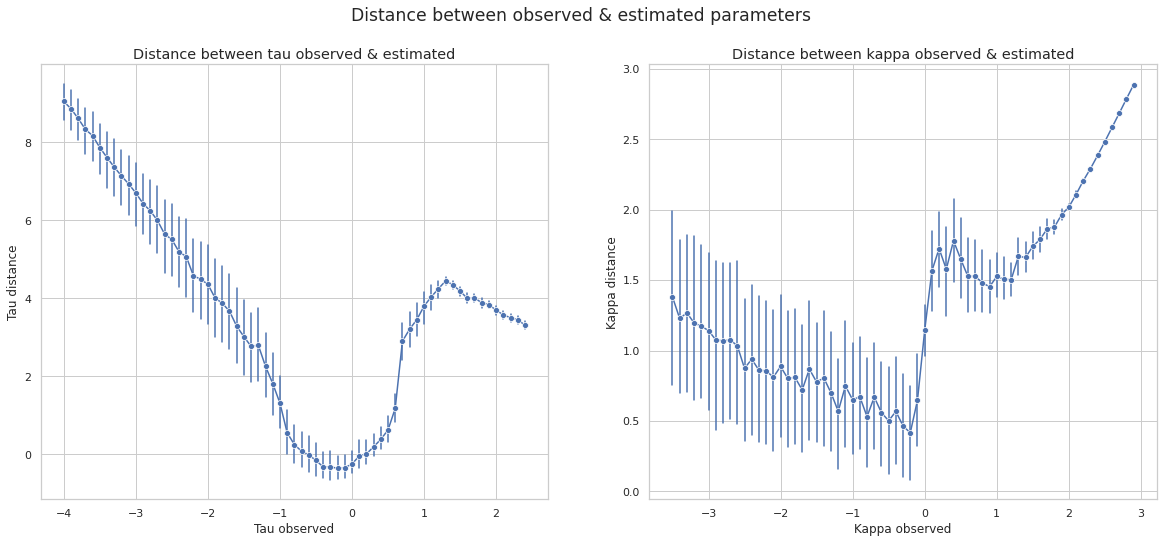

In [26]:
plot_distance(df)

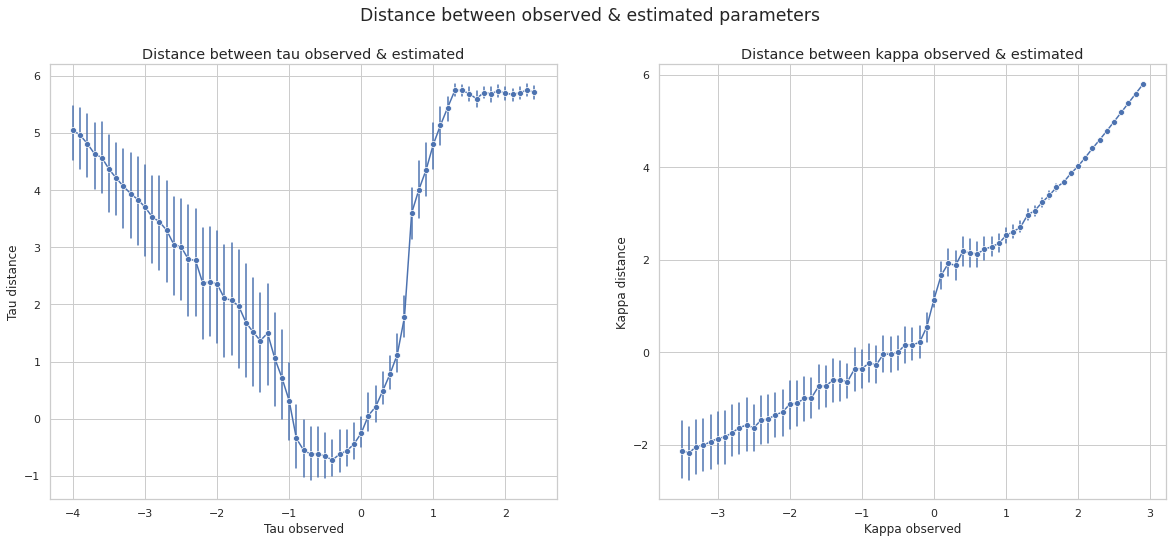

In [41]:
plot_distance(df)

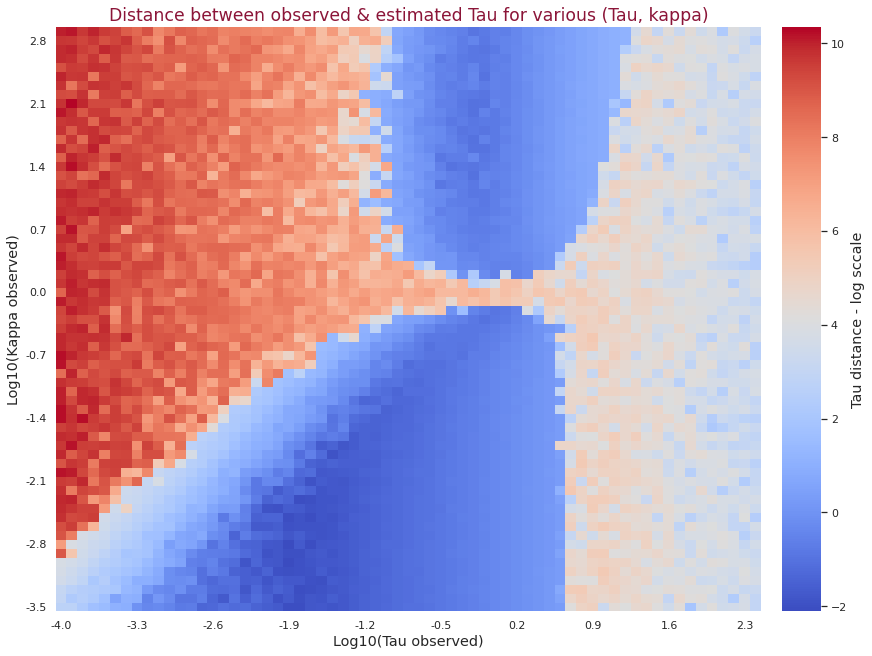

In [53]:
plot_inference_dadi_heatmap(df, 'Tau distance')

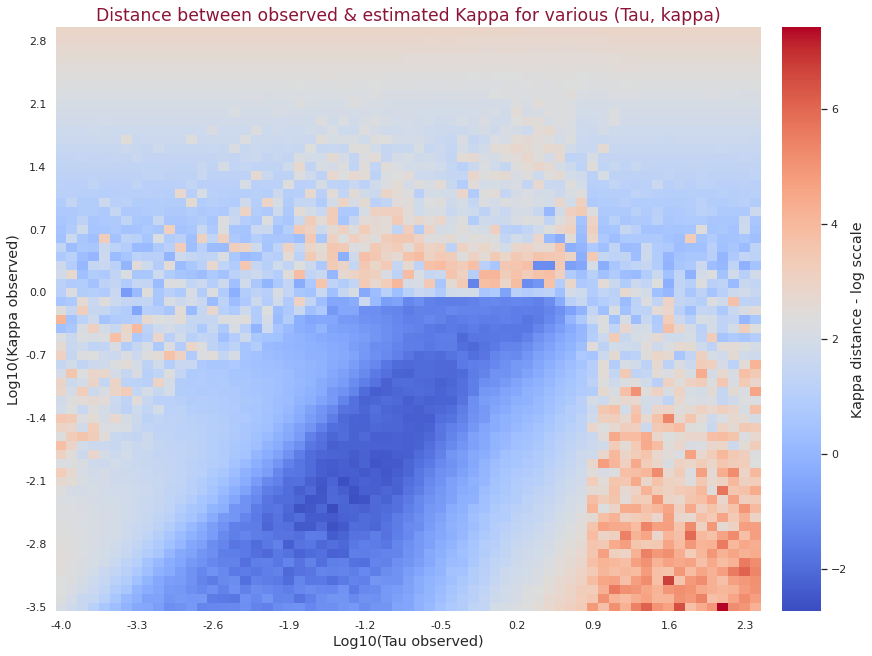

In [54]:
plot_inference_dadi_heatmap(df, 'Kappa distance')

<br>

### Fixed kappa - sudden decline & growth model 

> Load data

In [19]:
data_2 = f.export_inference_files('decline', 'kappa', 2)
data_10 = f.export_inference_files('decline', 'kappa', 10)

<br>

> Weighted square distance

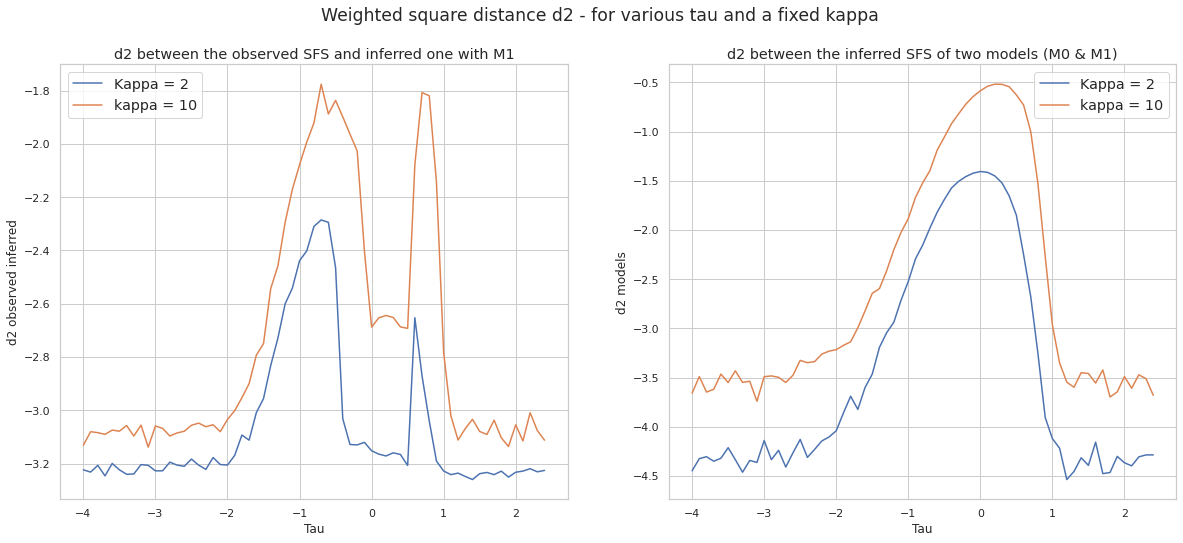

In [20]:
plot_weighted_square_distance(
    data=[data_2, data_10], key="Tau", 
    labels=['Kappa = 2', 'kappa = 10'],
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa")

<br>

> SFS shape verification

def  compute_theoritical_sfs(length):
    theoritical_sfs = [0] * (length)
    for i in range(len(theoritical_sfs)):
        theoritical_sfs[i] = 1 / (i+1)
    return theoritical_sfs


def normalization_sfs(sfs):
    return [ele / sum(sfs) for ele in sfs]


def plot_sfs_simulation(data):
    # Retrieve SFS and parameters (tau, kappa) 
    sfs, params = [], []
    for _, row in data.iterrows():
        if round(np.log10(row['Parameters']['Tau']), 2) in [round(ele, 2) for ele in np.arange(-4, -3, 0.5)]:
            # Parameters
            tmp = {'Tau': row['Parameters']['Tau'], 'Kappa': round(row['Parameters']['Kappa'], 2)}
            params.append(tmp)
        
            # SFS
            observed_sfs = row['SFS observed'][0]
            inferred_sfs = row['M1']['SFS'][0]
            theoritical_sfs = normalization_sfs(compute_theoritical_sfs(len(observed_sfs)))
            sfs.append({'Observed': observed_sfs, 'Inferred': inferred_sfs, 'Theoritical': theoritical_sfs})
        
    # Color and style
    color = {'Observed': "tab:blue", 'Inferred': "tab:orange", 'Theoritical': "tab:red"}
    style = {'Observed': "solid", 'Inferred': "solid", 'Theoritical': "dashed"}
    
    # Set up plot
    _, axs = plt.subplots(len(sfs), figsize=(10, len(sfs)*4), constrained_layout=True, sharex=True)
    
    # Plot
    for i, spectrum in enumerate(sfs):
        
        cpt = 0
        for key in spectrum.keys():
            # Label
            if key == 'Theoritical':
                label = "Theoritical SFS of any constant population"
            else:
                label = "{} SFS - tau={} & kappa={}".format(key, params[i]['Tau'], params[i]['Kappa'])
                
            # Plot
            axs[i].plot(spectrum[key], color=color[key], linestyle=style[key], label=label)
            
            cpt += 1
                   
        # Caption
        axs[i].legend(loc="upper right", fontsize="medium")

        # Y axis label
        axs[i].set_ylabel("Percent of SNPs", fontsize="x-large")
        
       
    # X axis label & values
    plt.xlabel("Allele frequency", fontsize="x-large")
        
    x_ax, x_values = [], []
    for j in range(len(spectrum['Observed'])):
        x_ax.append(j)
        x_values.append("{}/{}".format(j+1, len(spectrum['Observed'])+1))
    plt.xticks(x_ax, x_values)

    plt.show()

In [21]:
#plot_sfs_simulation(data_2)

In [22]:
#plot_sfs_simulation(data_10)

<br>

> Log-likelihood ratio test

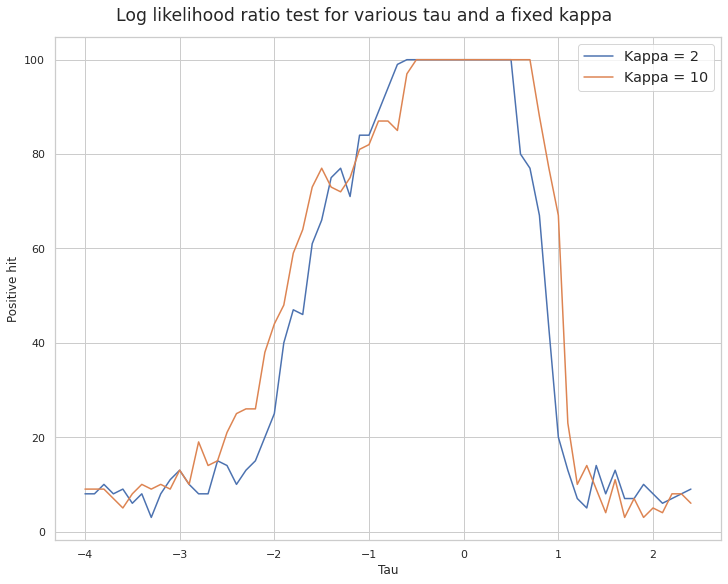

In [23]:
plot_inference_dadi(
    data=[data_2, data_10], key="Tau",
    labels=['Kappa = 2', 'Kappa = 10'],
    suptitle="Log likelihood ratio test for various tau and a fixed kappa")

<br>

### Fixed tau - sudden decline & growth model 

> Load data

In [24]:
data_1 = f.export_inference_files('decline', 'tau', 1)

<br>

> Weighted square distance

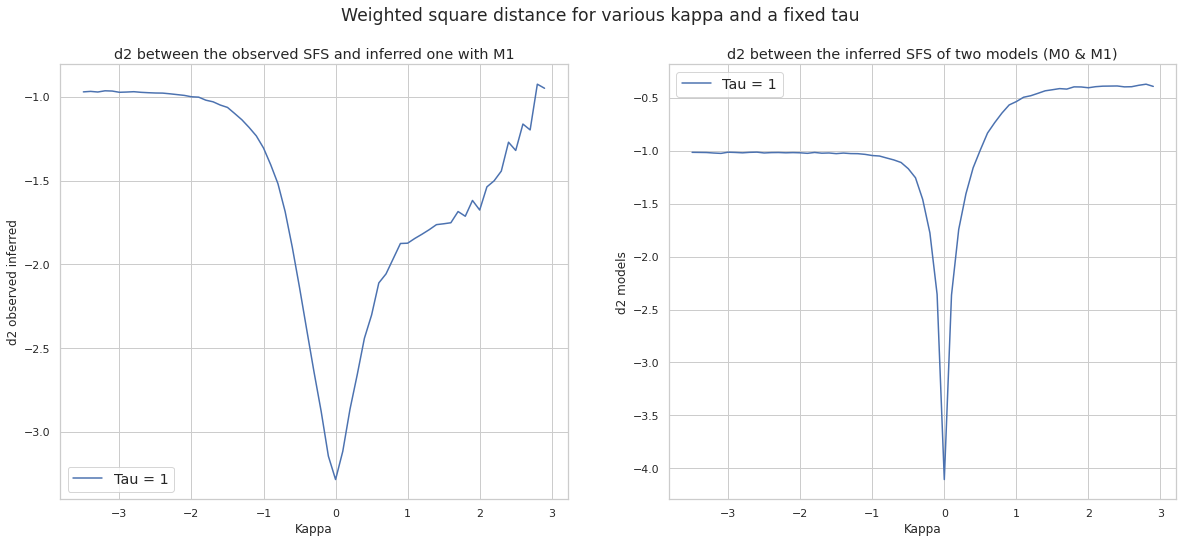

In [25]:
plot_weighted_square_distance(
    data=[data_1], key="Kappa", 
    labels=['Tau = 1'],
    suptitle="Weighted square distance for various kappa and a fixed tau")

<br>

> Log-likelihood ratio test

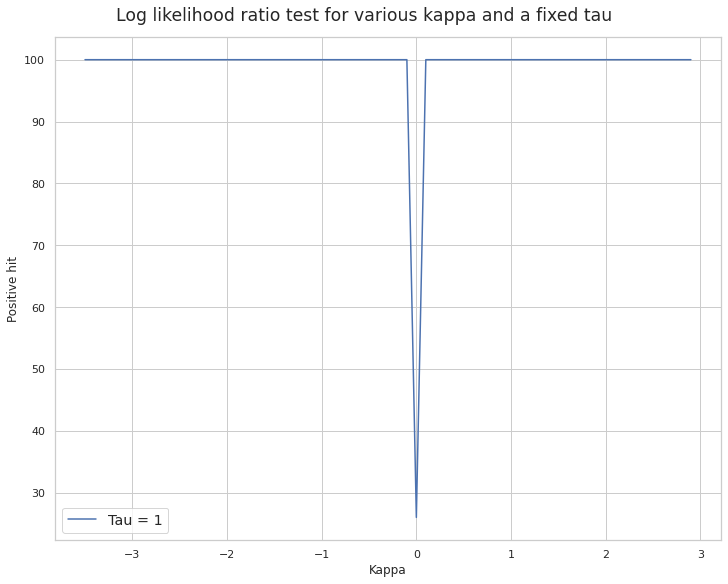

In [26]:
plot_inference_dadi(
    data=[data_1], key="Kappa",
    labels=['Tau = 1'],
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

<br>

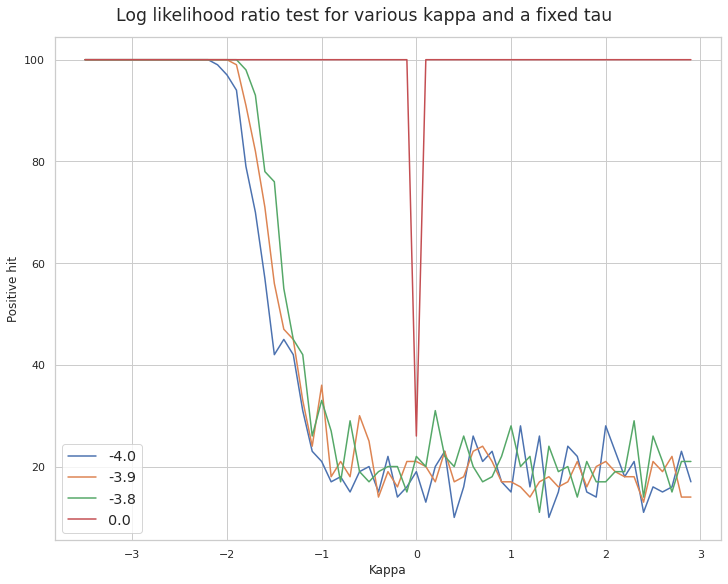

In [27]:
data, labels = [], []
for value in [0.0001, 0.00012589254117941674, 0.00015848931924611142, 1]:
    data.append(f.export_inference_files('decline', 'tau', value))
    labels.append(round(np.log10(value), 2))
    
plot_inference_dadi(
    data=data, key="Kappa",
    labels=labels,
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")